# **Ch03-b. Fine-tuning on 104 flowers**

* 改用另一個資料集 '104 flowers', 它共有 104種花卉的23000多張影像
* 這個資料集中, `某些類別有數千張影像, 也有些類別只有不到百張`, 這很好地反映了現實生活中資料集可能發生的狀況！
* 因此, `accuracy 在這種情況並不是一個好的指標`, 我們將改用 `precision, recall, f1 score`!

### Precision (精確度), Recall (召回率) & F1 Score
* Precision: 識別為陽性的個案中 真陽性的比例, TruePositive / (TruePositive + FalsePositive)
* Recall: 所有真陽性個案中 被成功識別的比例, TruePositive / (TruePositive + FalseNegative)
* F1 score: precision 與 recall 的調和平均值(harmonic mean), 2 / (1 / precision + 1 / recall)

### * 💡`Think`: 為什麼 accuracy 有時候不準？
* 假設 一個空間裡有 10000個好人 和 10個壞人, 且 監視系統成功識別好人的準確率是99%
* 如果兩者加起來單純計算準確率, 那一定很高啊！但它不能很好的顯示這個系統對於識別壞人方面的表現
* 所以需要「好人被誤認為壞人」「壞人被誤認為好人」這兩項指標！

In [1]:
import math, re, os, sys
import tensorflow as tf
import numpy as np
import statistics
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.19.0


In [2]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
REPLICAS:  1


---
## **Xception**

#### 實驗 1: 不同學習率曲線對 precision, recall & f1 score 的影響

In [ ]:
GCS_DS_PATH = "gs://one-hundred-flowers-public"

# Settings for TPUv3. When running on hardware with less memory such as a TPUv2 (Colab)
# or a GPU, you might have to use lower BATCH_SIZE and/or IMAGE_SIZE values.

IMAGE_SIZE = [512, 512] # available image sizes in flowers104 dataset: 512x512, 331x331, 224x224, 192,192
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
EPOCHS = 12

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 2
LR_EXP_DECAY = .7

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

圖示化三種 learning rate 曲線

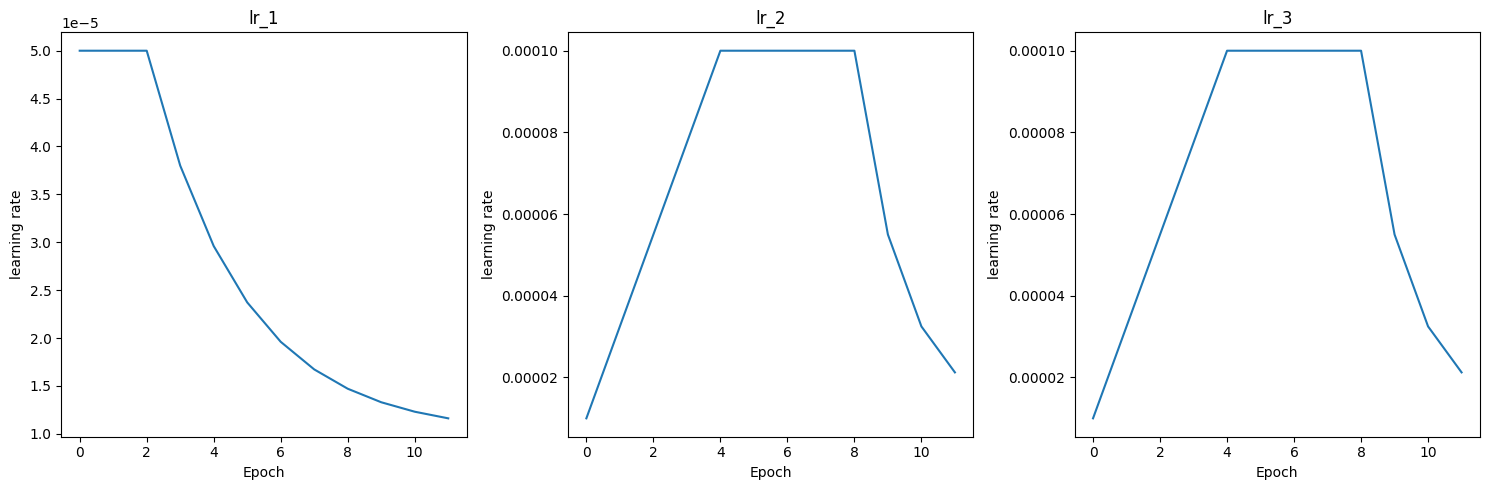

In [12]:
EPOCHS = 12

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
# lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn_1, verbose=True)

f, ax = plt.subplots(1, 3, figsize=(15, 5))
rng = [i for i in range(EPOCHS)]

# 第一種: 沒有 warm-up ramp, 也沒有 differential learning rate
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 2
LR_EXP_DECAY = .7
y_1 = [lrfn(x) for x in rng]

# 第二種: 有 warm-up ramp, 但沒有 differential learning rate
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .5
y_2 = [lrfn(x) for x in rng]

# 第三種: 有 warm-up ramp, 也有 differential learning rate
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .5
mult_by_layer={ 
            'flower_prob': 1.0,
            'block1_': 0.1,
            'block2_': 0.15,
            'block3_': 0.2,
            'block4_': 0.25,
            'block5_': 0.3,
            'block6_': 0.35,
            'block7_': 0.4,
            'block8_': 0.45,
            'block9_': 0.5,
            'block10_': 0.6,
            'block11_': 0.7,
            'block12_': 0.8,
            'block13_': 0.9,
            'block14_': 0.95,
            # these layers do not have stable identifiers in tf.keras.applications.Xception
            'conv2d_': 0.5,
            'batch_normalization_': 0.5
}
y_3 = [lrfn(x) for x in rng]

ax[0].plot(rng, y_1)
ax[0].set_title('lr_1')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('learning rate')

ax[1].plot(rng, y_2)
ax[1].set_title('lr_2')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('learning rate')

ax[2].plot(rng, y_3)
ax[2].set_title('lr_3')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('learning rate')

plt.tight_layout()
plt.show()
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

上圖是這次實驗使用的三種 learning rate 曲線 (2 & 3 看起來一樣, 是因為 3 多的是 layer-wise learning rate, 跟 epoch 沒有關係)

#### 實驗1: 結果

|   類別  |  warm-up ramp  |  differential learning rate | result: f1 score |  5次標準差  |        分析       |  
| -------- | -------------- | --------------------------- | ----------------- | ---------- | ------------------------------------- |  
|  lr_1  |       NO       |              NO             |       0.932      |    0.004   |    好, 變異數不高   |
|  lr_2  |      YES       |             YES             |       0.934      |    0.007   |  很好, 但變異數較高  |
|  lr_3  |      YES       |             YES             |       0.936      |    0.003   |  最佳, 且變異數低    |

由上述結果可見, warm-up ramp 與 differential learning rate 都不是必要的, 但`在實務上他們會使收斂更加穩定, 糗更容易找到可行的學習率參數`